In [1]:
import tensorflow as tf
import numpy as np
from model import LSTM
import os, re, glob
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import skimage
import skimage.io

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

from sklearn.manifold import TSNE

from reader import *

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
video_path_train = '/data/put_data/cclin/ntu/dlcv2018/hw5/HW5_data/TrimmedVideos/video/train'
label_file_train = '/data/put_data/cclin/ntu/dlcv2018/hw5/HW5_data/TrimmedVideos/label/gt_train.csv'
feature_path_train = '/data/put_data/cclin/ntu/dlcv2018/hw5/cnn_features_train.npy'

video_path_valid = '/data/put_data/cclin/ntu/dlcv2018/hw5/HW5_data/TrimmedVideos/video/valid'
label_file_valid = '/data/put_data/cclin/ntu/dlcv2018/hw5/HW5_data/TrimmedVideos/label/gt_valid.csv'
feature_path_valid = '/data/put_data/cclin/ntu/dlcv2018/hw5/cnn_features_valid.npy'

In [3]:
dir_name = 'cnn_lstm1024_1024_msl25_h512_bs32_lr5e5_ep50_dropout'
result_path = '/data/put_data/cclin/ntu/dlcv2018/hw5/results'
msl = 25
n_class = 11
h = 1024
bsize = 32
learning_rate = 5e-5
keep_prob = 0.8
num_epoch = 50

### Train the discriminative model

In [4]:
tf.reset_default_graph()

with tf.Session() as sess:
    net = LSTM(sess,
               model_name=dir_name,
               max_seq_len=msl,
               h_dim=h)
    net.build_model(use_static_rnn=False)
    results = net.train(feature_path_train=feature_path_train,
                        bsize=bsize,
                        learning_rate=learning_rate,
                        keep_prob=keep_prob,
                        num_epoch=num_epoch)

Epoch: 1, train loss: 1.968106, valid loss: 1.690970, train accuracy: 0.336943, valid accuracy: 0.425000
Epoch: 2, train loss: 1.255731, valid loss: 1.583381, train accuracy: 0.669554, valid accuracy: 0.451838
stopping_step = 0
Epoch: 3, train loss: 0.665859, valid loss: 1.569789, train accuracy: 0.883663, valid accuracy: 0.469118
stopping_step = 0
Epoch: 4, train loss: 0.300188, valid loss: 1.528046, train accuracy: 0.971225, valid accuracy: 0.511397
stopping_step = 0
Epoch: 5, train loss: 0.152073, valid loss: 1.520560, train accuracy: 0.991027, valid accuracy: 0.496691
stopping_step = 0
Epoch: 6, train loss: 0.088544, valid loss: 1.520544, train accuracy: 0.997215, valid accuracy: 0.523897
stopping_step = 0
Epoch: 7, train loss: 0.055154, valid loss: 1.538607, train accuracy: 0.999072, valid accuracy: 0.504044
stopping_step = 1
Epoch: 8, train loss: 0.038418, valid loss: 1.545838, train accuracy: 0.999691, valid accuracy: 0.510294
stopping_step = 2
Epoch: 9, train loss: 0.028810, va

### t-SNE

In [5]:
## load labels
label_file = label_file_valid
video_list = getVideoList(label_file)
labels = [int(s) for s in video_list['Action_labels']]

#### (1) CNN features

In [6]:
cnn_features = np.load(feature_path_valid)
print(type(cnn_features))
print(len(cnn_features))
print(type(cnn_features[0]))
print(cnn_features[0].shape)

<class 'numpy.ndarray'>
517
<class 'numpy.ndarray'>
(6, 40960)


In [7]:
## http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
## The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms.
## Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50.
## The choice is not extremely critical since t-SNE is quite insensitive to this parameter.
cnn_features_mean = np.array([np.mean(f, axis=0) for f in cnn_features])
print(cnn_features_mean.shape)
cnn_features_2d = TSNE(n_components=2, perplexity=30.0, random_state=1002).fit_transform(cnn_features_mean)
print(cnn_features_2d.shape)

(517, 40960)
(517, 2)


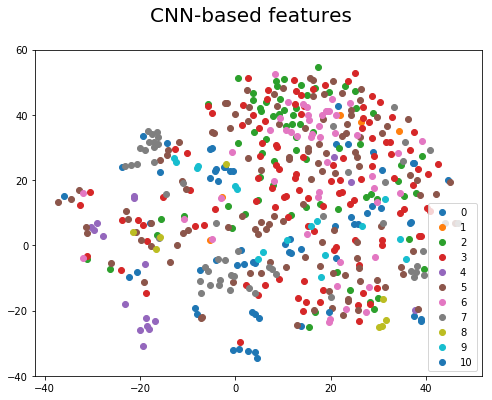

In [8]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,6))
for i in range(n_class):
    cnn_features_2d_temp = cnn_features_2d[[label==i for label in labels],:]
    ax.scatter(cnn_features_2d_temp[:,0], cnn_features_2d_temp[:,1], label=i)
plt.legend()
plt.suptitle('CNN-based features', fontsize=20)
fig.savefig(os.path.join(result_path, dir_name, 'cnn_tsne.jpg'),
            bbox_inches='tight')
plt.show()

#### (2) Extract RNN features

In [9]:
video_path = video_path_valid
gen_from = os.path.join(result_path, dir_name, 'models')
gen_from_ckpt = None
output_folder = result_path

In [10]:
tf.reset_default_graph()

with tf.Session() as sess:
    net = LSTM(sess,
               model_name=dir_name,
               max_seq_len=msl,
               h_dim=h)
    net.build_model()
    out_path = output_folder
    ## load previous model if possible
    could_load, checkpoint_counter = net.load(gen_from, gen_from_ckpt)
    if could_load:
        print(" [*] Load SUCCESS")
        
        features = cnn_features
        nBatches = int(np.ceil(len(features) / bsize))
        ## down-sampling to make sure all videos have number of frames <= msl
        features_new = []
        for v_idx in range(len(features)):
            n_frames = features[v_idx].shape[0]
            step = (n_frames - 1) // msl + 1
            features_new.append(features[v_idx][np.arange(0,n_frames,step),:])
        ## make labels one-hot vectors
        labels_vec = np.eye(n_class)[labels]
        
        rnn_features = []
        for idx in range(nBatches):
            batch_features = features_new[idx*bsize:(idx+1)*bsize]
            ### padding 0
            batch_features_pad = np.array([np.vstack((f, np.zeros((msl - f.shape[0], f.shape[1])))) \
                                           if f.shape[0] < msl \
                                           else f[0:msl] \
                                           for f in batch_features])
            batch_labels = labels_vec[idx*bsize:(idx+1)*bsize]
            batch_seqlen = np.array([np.min((f.shape[0], msl)) for f in batch_features], dtype=np.int32)
            outputs = net.sess.run(net.outputs,
                                   feed_dict={net.features: batch_features_pad,
                                              net.labels: batch_labels,
                                              net.seqlen: batch_seqlen,
                                              net.bn_train: False})
            rnn_features.extend(outputs)

INFO:tensorflow:Restoring parameters from /data/put_data/cclin/ntu/dlcv2018/hw5/results/cnn_lstm1024_1024_msl25_h512_bs32_lr5e5_ep50_dropout/models/cnn_lstm1024_1024_msl25_h512_bs32_lr5e5_ep50_dropout.model-6
 [*] Success to read cnn_lstm1024_1024_msl25_h512_bs32_lr5e5_ep50_dropout.model-6
 [*] Load SUCCESS


In [11]:
print(type(rnn_features))
print(len(rnn_features))
print(type(rnn_features[0]))
print(rnn_features[0].shape)

<class 'list'>
517
<class 'numpy.ndarray'>
(1024,)


In [12]:
## http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
## The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms.
## Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50.
## The choice is not extremely critical since t-SNE is quite insensitive to this parameter.
rnn_features = np.array(rnn_features)
print(rnn_features.shape)
rnn_features_2d = TSNE(n_components=2, perplexity=30.0, random_state=1002).fit_transform(rnn_features)
print(rnn_features_2d.shape)

(517, 1024)
(517, 2)


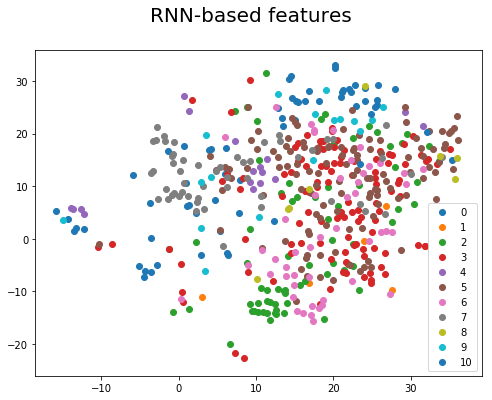

In [13]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,6))
for i in range(n_class):
    rnn_features_2d_temp = rnn_features_2d[[label==i for label in labels],:]
    ax.scatter(rnn_features_2d_temp[:,0], rnn_features_2d_temp[:,1], label=i)
plt.legend()
plt.suptitle('RNN-based features', fontsize=20)
fig.savefig(os.path.join(result_path, dir_name, 'rnn_tsne.jpg'),
            bbox_inches='tight')
plt.show()